<table style="width:100%">
    <tr style="background-color:white;">
        <td style="text-align:left;padding-bottom:10%;padding-right:10%">
            <table>
                <tr><td style="background-color:white;text-align:left;font-size:15px">COMP0036 Assignment 2</td></tr>
                <tr><td style="text-align:left;font-size:15px">Term 1, 2018</td></tr>
  </table>
        
  </td>
        <td style="text-align:center;padding-right:7%"><img src="ucl logo.jpeg"></td>
        <td style="padding-bottom:10%">
    <table>
                <tr><td style="background-color:white;text-align:right;font-size:15px">Team A</td></tr>
                <tr><td style="background-color:white;text-align:right;font-size:15px">Team Member:Chaojie Ling,Kaihan Huang</td></tr>
  </table>
</td>
    </tr>
    <tr>
    </tr>
</table>
<h1 align='center'>“Beat the Bookie”</h1>
<h2 align='center'>Practical Application of Machine Learning to a Real World Problem</h2>
<h3 align='center'>COMP0036 Assignment 2</h3>

<h1>Introduction</h1>

<p>
The goal of the problem is to predict the EPL matches using the team features. The result of a match is either home team win, away team win or draw. Therefore, it's a multi-class classification. In our work, we compare four different multi-class classifiers with regard to their predictive performances based on the previous matches from EPL. There are four main steps to solve the problem:

1. Data pre-processing to get the features of input
2. Split the training and testing set using sklean
3. Train 4 different classifiers, XGBoost Classifier, Gaussian Naive Bayes Classifier, KNN Classifier and Logistic Regression
4. Use the best classifier to predict the result of a match

In our case, the best classifier is Logistic Regression with 54.11255% correctness.
</p>

<h1>Data Import</h1>

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import time
import numpy as np
import datetime
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display


def get_MatchesData():
    MID = []
    FTRs = []
    HTRs = []
    data = pd.read_csv('epl-training.csv')
    data.Date = pd.to_datetime(data.Date, errors='coerce')
    for index, row in data.iterrows():
        MID.append(index)
        # 0 for draw
        if row.FTR == 'D':
            FTRs.append(0)
        if row.HTR == 'D':
            HTRs.append(0)
        # -1 for away wins
        if row.FTR == 'A':
            FTRs.append(-1)
        if row.HTR == 'A':
            HTRs.append(-1)
        # 1 for home wins
        if row.FTR == 'H':
            FTRs.append(1)
        if row.HTR == 'H':
            HTRs.append(1)
    newdf = pd.DataFrame({'FTR': FTRs, 'HTR':HTRs})
    data.update(newdf)
    data['MatchID'] = MID
    return data

data = get_MatchesData()
display(data.head())

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,MatchID
0,2005-08-13,Aston Villa,Bolton,2,2,0,2,2,0,M Riley,...,6,14,16,7,8,0,2,0,0,0
1,2005-08-13,Everton,Man United,0,2,-1,0,1,-1,G Poll,...,5,15,14,8,6,3,1,0,0,1
2,2005-08-13,Fulham,Birmingham,0,0,0,0,0,0,R Styles,...,4,12,13,6,6,1,2,0,0,2
3,2005-08-13,Man City,West Brom,0,0,0,0,0,0,C Foy,...,3,13,11,3,6,2,3,0,0,3
4,2005-08-13,Middlesbrough,Liverpool,0,0,0,0,0,0,M Halsey,...,7,17,11,5,0,2,3,1,0,4


<p>We converted categorical values of FTR, ('A','D','H') to numeric values (1,0,-1) for later training perpose. And we created an extra column, MatchID, for the later data processing.</p>

<h1>Data Transformation and Exploration</h1>

<p>Instead of using the whole dataset as the input features, we decided to calculate our own features from the exsiting dataset, which we believe they could reflect the strength of a team.
Calculated Features:
    <ul type= 'circle'>
        <li>WR : Win rate of a team </li>
        <li>AG : Average goal of a team </li>
        <li>ACG : Average concided goal of a team </li>
        <li>AC : Average corners of a team </li>
        <li>As : Average shots on target of a team </li>
</ul>
</p>

<p>Get the previous 11 matches of a team</p>

In [12]:
def get_LastNmatches(date, team, x = 11):
    matchedMatches = data[(data['HomeTeam'] == team) | (data['AwayTeam'] == team)]
    lastnMatches = matchedMatches[matchedMatches.Date < date].sort_values(by = 'Date', ascending = False).iloc[0:x,:]
    return lastnMatches

<p>Get the total number of goals of a team during the past 11 matches</p>

In [13]:
def get_Goals(matches, team):
    homeGoal = matches.FTHG[matches.HomeTeam == team].sum()
    awayGoal = matches.FTAG[matches.AwayTeam == team].sum()
    return homeGoal + awayGoal

<p>Get the total number of conceided goals of a team during the past 11 matches</p>

In [14]:
def get_Conceided_Goals(matches, team):
    homeConceided = matches.FTAG[matches.HomeTeam == team].sum()
    awayConceided = matches.FTHG[matches.AwayTeam == team].sum()
    return homeConceided + awayConceided

<p>Get the total number of shots on target of a team during the past 11 matches</p>

In [15]:
def get_Shots(matches, team):
    homeHST = matches.HST[matches.HomeTeam == team].sum()
    awayHST = matches.HST[matches.AwayTeam == team].sum()
    return homeHST + awayHST


<p>Get the total number of corners of a team during the past 11 matches</p>

In [16]:
def get_Corner(matches, team):
    homeConer = matches.HC[matches.HomeTeam == team].sum()
    awayConer = matches.HC[matches.AwayTeam == team].sum()
    return homeConer + awayConer

<p>Get the calculated features of a team</p>

In [17]:
def get_MatchesData(matches,team, number):

    # if there's no 11 enough matches history, return NaT
    if (matches.shape[0] < number):
        return (pd.NaT,pd.NaT,pd.NaT,pd.NaT,pd.NaT)

    else:

        homeWin = 0
        awayWin = 0

        homeMatches = matches[matches.HomeTeam == team]
        awayMatches = matches[matches.AwayTeam == team]

        totalMatches = homeMatches.shape[0] + awayMatches.shape[0]

        for index, row in homeMatches.iterrows():
            if (row.FTR == 1):
                homeWin += 1

        for index, row in awayMatches.iterrows():
            if (row.FTR == -1):
                awayWin += 1

        WR = (homeWin + awayWin)/totalMatches * 100

        AG = get_Goals(matches,team)/totalMatches       # Average goal of a team
        ACG = get_Conceided_Goals(matches, team)/totalMatches # Average conceided goal of a team
        AC = get_Corner(matches,team)/totalMatches # Average corners of a team
        AS = get_Shots(matches,team)/totalMatches # Average shots on target of a team

        return (WR,AG,ACG,AC,AS)

<p>Create input X from datasets</p>

In [18]:
def get_MatchFeatures(match, number = 11):

    date = match.Date
    home = match.HomeTeam
    away = match.AwayTeam

    homeTeamMatch = get_LastNmatches(date,home, x= number)
    awayTeamMatch = get_LastNmatches(date,away, x= number)

    HWR,HAG,HACG,HAC,HAS = get_MatchesData(homeTeamMatch,home,number)

    AWR,AAG,AACG,AAC,AAS = get_MatchesData(awayTeamMatch,away,number)

    features = pd.DataFrame()

    features.loc[0, 'MatchID'] = match.MatchID
    features.loc[0, 'HAG'] = HAG   # Home team average goal
    features.loc[0, 'AAG'] = AAG   # Away team average goal
    features.loc[0, 'HACG'] = HACG  # Home team average conceided goal
    features.loc[0, 'AACG'] = AACG  # Away team average conceided goal
    features.loc[0, 'WinDiff'] = HWR - AWR  # Home team win rate - Away team win rate
    features.loc[0, 'CornerDiff'] = HAC - AAC # Home team average corners - Away team average corners
    features.loc[0, 'ShotDiff'] = HAS - AAS # Home team average shots - Away team average shots

    return features.loc[0]

<p>Create X and Y for training purpose</p>

In [20]:
def createTable():

    matchFeatures = pd.DataFrame()
    temp = pd.DataFrame()

    matchFeatures['HomeTeam'] = data.HomeTeam
    matchFeatures['AwayTeam'] = data.AwayTeam
    matchFeatures['MatchID'] = data.MatchID
    matchFeatures['FTR'] = data.FTR.astype('int') # convert type str to int


    for index, match in data.iterrows():
        MF = get_MatchFeatures(match)
        temp = temp.append(MF)

    result = pd.merge(matchFeatures, temp, on='MatchID')
    result = result[
        ['MatchID', 'HomeTeam', 'AwayTeam', 'HAG', 'AAG', 'HACG', 'AACG', 'WinDiff', 'CornerDiff', 'ShotDiff', 'FTR'
         ]]

    result.dropna(inplace=True)

    result.drop(['MatchID', 'HomeTeam', 'AwayTeam'], axis=1, inplace=True)  # X table

    label = result['FTR'] # Y table

    result.drop(['FTR'], axis=1, inplace=True)

    return (result,label)

X,Y = createTable()
table = X
table['FTR'] = Y
display(table.head())

,HAG,AAG,HACG,AACG,WinDiff,CornerDiff,ShotDiff,FTR
109,0.909091,1.272727,1.363636,0.818182,-36.363636,0.272727,-0.181818,1
110,1.000000,0.636364,0.909091,1.454545,27.272727,-0.454545,0.454545,1
115,1.181818,1.181818,1.000000,0.636364,9.090909,1.181818,0.272727,1
116,1.454545,1.454545,1.272727,1.000000,0.000000,0.090909,-0.090909,-1
117,2.454545,1.090909,0.636364,0.727273,36.363636,-1.363636,-0.363636,1


<h2>Feature Selection</h2>
<p>We used pd.plotting.scatter_matrix to determine the relation between our features and result as shown below.</p>

<p>We take the past 11 matches as reference, and calculate win rate difference, average goals difference, average shots on target difference, average corners differenfce and average conceided goals difference. At first, we set N, the number of past matches taken account, to be 5. Then we loop through the value of N and found out that when N = 11, the classifiers with the same hyper parameters would reach the highest score.</p>

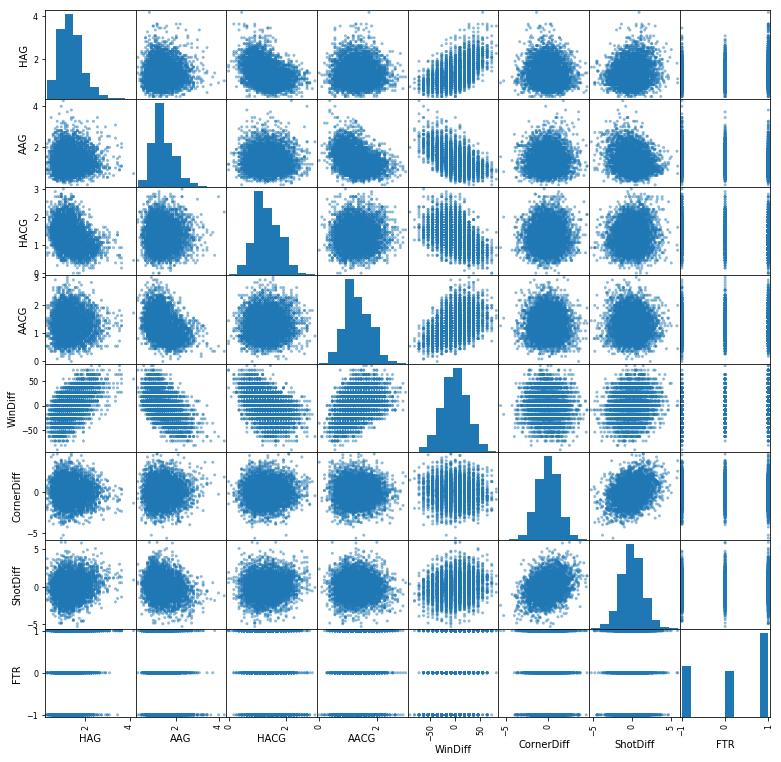

In [22]:
scatter_matrix(table, figsize = (13,13))
plt.show()

<h1>Methodology Overview</h1>

<p>In order to achieve our goal, we have done some background reading</p >
<ul type='circle'>
<li>
<a href=" ">Prediction of the FIFA World Cup 2018 – A random
forest approach with an emphasis on estimated team
</a ></li>
<li>
<a href="https://www.kaggle.com/c/march-machine-learning-mania-2017/kernels">Kaggle March Madness </a ></li>
<li>
<a href="https://arxiv.org/pdf/1511.05837.pdf">Using Machine Learning to Predict the
Outcome of English County twenty over Cricket Matches</a ></li>
<li>
<a href="https://qz.com/233830/world-cup-germany-argentina-predictions-microsoft/">With Germany’s win Microsoft perfectly predicted the World Cup’s knockout round</a ></li>
</ul>

<p>
From our perspective, the outcome of a match is based on the strength of both teams. So we decided to find such a feature, which can represent the strength of each team. At first, we planed to use EPL ranking like Elo but it doesn't perform very well since the team members and coach always change over year. Then we find another way to represent the ELP ranking by integrating some statical features to form some new features called 'ralative attack strength index', e.g. number of shots on target, and 'relative defense strength index', e.g. number of conceided goal. However, it didn't turn out to a very good result as well. 

<p>Finally, we came up with a solution to represent the strength of a team resonably. We take the past 11 matches as reference, and calculate win rate difference, average goals difference, average shots on target difference, average corners differenfce and average conceided goals difference. At first, we set N, the number of past matches taken account, to be 5. Then we loop through the value of N and found out that when N = 11, the classifiers with the same hyper parameters would reach the highest score.</p>

<p>As regard to dimension reduction, we applied PCA to our features. However, it didn't turn out to a good result since in our case. We only got 7 features, which are obtained by calculation, this is way, the dimension of features is already reduced compared to the raw data.</p>

<p>
We decided to use four classifiers, XGB Classifier, GNB Classifier, KNN Classifier and Logistic Regression.Logistic regression seeks to design the possibility of an event occurring based on values of independent variables, that could be categorical or numerical. It is a statistical method that operates on data-sets having one or more independent variables which decide an outcome. The objective of this method is to compute the perfect fitting model that describes the interrelationship amidst the dependent variable and a list of independent (predictory) variables. Our problem is a multi-class classification problem as there exists more than two possible outcomes i.e, Home Win, Draw and Away Win. Hence we are going to be using Multinomial Logistic Regression.
</p>
</p>

<h1>Model Training/Validation</h1>

<p>
We train each of the classifier with the training and testing dataset, and evaluate it by sklearn.metrics accuracy_score. We loop through a certain range of the value of hypter parameters, and obtained the best pipeline for each classifier. And use the classifier with the best hyper parameters to predict the match.
</p>

/Users/alvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/alvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/alvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/alvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/alvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

Best KNN score:  0.5270562770562771  with n equals to  46
Best Logistic Regression score:  0.5411255411255411  with c equals to  2.9099999999999806
Best XGB Classifier score:  0.48917748917748916  with n equals to  43
GNB Classifier score:  0.5367965367965368


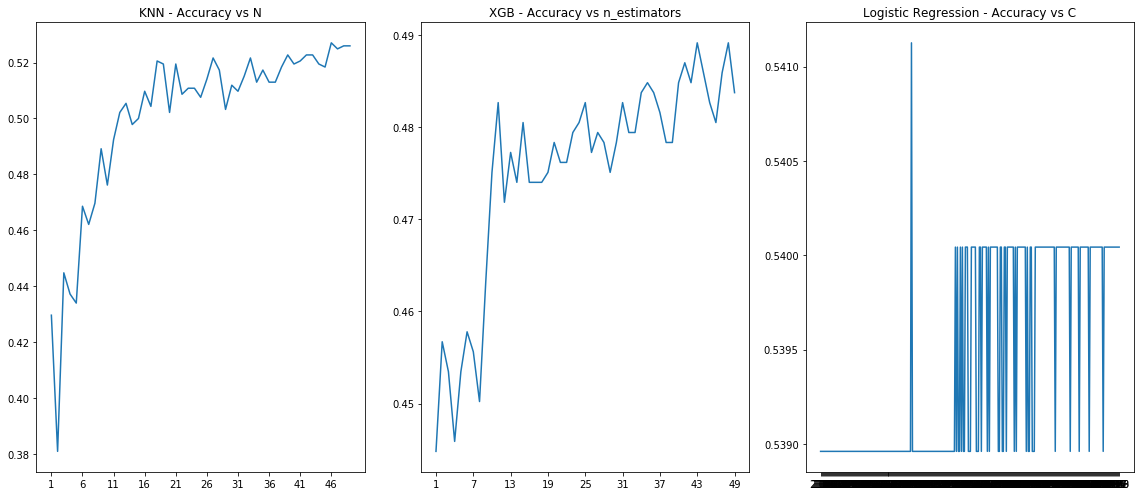

In [25]:
def getOptimalClassifier():

    XGB = {'name':'XGB','clf':None,'score':0, 'n':-1}
    LOG = {'name':'LOG','clf':None,'score':0, 'n':-1}
    KNN = {'name':'KNN','clf':None,'score':0, 'n':-1}

    matchFeatures = pd.DataFrame()

    matchFeatures['HomeTeam'] = data.HomeTeam
    matchFeatures['AwayTeam'] = data.AwayTeam
    matchFeatures['MatchID'] = data.MatchID
    matchFeatures['FTR'] = data.FTR.astype('int')

    temp = pd.DataFrame()
    for index, match in data.iterrows():
        # calculate the seven features from each match
        MF = get_MatchFeatures(match)
        temp = temp.append(MF)

    result = pd.merge(matchFeatures, temp, on='MatchID')
    result = result[
            ['MatchID', 'HomeTeam', 'AwayTeam', 'HAG', 'AAG', 'HACG', 'AACG', 'WinDiff', 'CornerDiff', 'ShotDiff', 'FTR'
             ]]


    result.dropna(inplace=True) # drop NA value


    result.drop(['MatchID', 'HomeTeam', 'AwayTeam'], axis=1, inplace=True) # drop irrevelant columns


    label = result['FTR']

    result.drop(['FTR'], axis=1, inplace=True)

    # split the test and train sets
    X_train, X_test, Y_train, Y_test = train_test_split(result,label,test_size=0.2,random_state=43)

    # XBG
    plot_scores_XGB = []
    for i in range(1, 50):
        clf_XGB = XGBClassifier(n_estimators=i, max_depth=100)
        clf_XGB.fit(X_train, Y_train)
        scores = accuracy_score(Y_test, clf_XGB.predict(X_test))
        plot_scores_XGB.append(scores)

        if (scores > XGB['score']):
            XGB['score'] = scores
            XGB['n'] = i
            XGB['clf'] = clf_XGB


    # Logistic Regression
    plot_scores_logreg = []
    cs = np.arange(2, 5, 0.01)
    for c in cs:
        clf_logreg = LogisticRegression(C=c, solver='lbfgs', multi_class='ovr')
        clf_logreg.fit(X_train, Y_train)
        scores = accuracy_score(Y_test, clf_logreg.predict(X_test))
        plot_scores_logreg.append(scores)
        if (scores > LOG['score']):
            LOG['score'] = scores
            LOG['n'] = c
            LOG['clf'] = clf_logreg

    # KNN
    plot_scores_knn = []
    for b in range(1, 50):
        clf_knn = KNeighborsClassifier(n_neighbors=b)
        clf_knn.fit(X_train, Y_train)
        scores = accuracy_score(Y_test, clf_knn.predict(X_test))
        plot_scores_knn.append(scores)
        if (scores > KNN['score']):
            KNN['score'] = scores
            KNN['n'] = b
            KNN['clf'] = clf_knn




    # GNB
    clf_GNB = GaussianNB()
    clf_GNB.fit(X_train, Y_train)
    GNB_scores = accuracy_score(Y_test, clf_GNB.predict(X_test))

    # plot the figure against each own hyper parameters
    fig = plt.figure(figsize=(16, 7))

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(range(1, 50), plot_scores_knn);
    ax1.set_title("KNN - Accuracy vs N")
    ax1.set_xticks(range(1, 50, 5));

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.plot(range(1, 50), plot_scores_XGB);
    ax2.set_xticks(range(1, 50, 6));
    ax2.set_title("XGB - Accuracy vs n_estimators")

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(np.arange(2, 5, 0.01), plot_scores_logreg);
    ax3.set_xticks(np.arange(2, 5, 0.01));
    ax3.set_title("Logistic Regression - Accuracy vs C")

    fig.tight_layout()

    print('Best KNN score: ', KNN['score'], ' with n equals to ', KNN['n'])
    print('Best Logistic Regression score: ', LOG['score'], ' with c equals to ', LOG['n'])
    print('Best XGB Classifier score: ', XGB['score'], ' with n equals to ', XGB['n'])
    print('GNB Classifier score: ', GNB_scores)

    best_clf = None
    
    if ((XGB['score'] > LOG['score']) & (XGB['score'] > KNN['score'])):
        best_clf = XGB
    elif((KNN['score'] > LOG['score']) & (KNN['score'] > XGB['score'])):
        best_clf = KNN
    elif((LOG['score'] > KNN['score']) & (LOG['score'] > XGB['score'])):
        best_clf = LOG
    return best_clf

best_clf = getOptimalClassifier()

<h1>Result</h1>

<p>
<ul type='circle'>
<li>Best KNN score:  0.5270562770562771  with n equals to  46</li>
<li>Best Logistic Regression score:  0.5411255411255411  with c equals to  2.9099999999999806</li>
<li>Best XGB Classifier score:  0.48917748917748916  with n equals to  43</li>
<li>GNB Classifier score:  0.5367965367965368</li>
</ul>
<p>The best classifier in our case is Logistic Regression with highest score 0.5411255411255411</p>
</p>

In [26]:
# convert (1,0,-1) to ('H', 'D', 'A')
def convertResult(n):
    if (n == 1):
        return 'H'
    elif (n == 0):
        return 'D'
    else:
        return 'A'

In [28]:
def test():

    testData = pd.read_csv('epl-test.csv')


    testData['MatchID'] = range(testData.shape[0])

    temp = pd.DataFrame()

    for index, row in testData.iterrows():
        temp = temp.append(get_MatchFeatures(row, 11))

    temp = temp[['HAG', 'AAG', 'HACG', 'AACG', 'WinDiff', 'CornerDiff', 'ShotDiff']] # reshpe shape of data to the 
                                                                                     #   shape of input X
    

    y_pred = best_clf['clf'].predict(temp)
    
    result = []
    
    for y in y_pred:
        result.append(convertResult(y))

    Output = pd.read_csv('epl-test.csv')
    Output['FTR'] = result
    
    Output.to_csv('epl-test.csv', index = False) # save result to csv
    
    display(Output[0:])

test()

,Date,HomeTeam,AwayTeam,FTR
0,12-Jan-19,Brighton,Liverpool,A
1,12-Jan-19,Burnley,Fulham,H
2,12-Jan-19,Cardiff,Huddersfield,H
3,12-Jan-19,Chelsea,Newcastle,H
4,12-Jan-19,Crystal Palace,Watford,H
5,12-Jan-19,Everton,Bournemouth,H
6,12-Jan-19,Leicester,Southampton,H
7,12-Jan-19,Man City,Wolves,H
8,12-Jan-19,Tottenham,Man United,H
9,12-Jan-19,West Ham,Arsenal,A
